# TensorFlow入門

今回はおもちゃのデータを作って、そのデータを再現するような関数：

$$
\mathbb{R}^2 \ni {\bf x} \to y \in \{0,1,2,3,4 \} 
$$

を作ってみます。

## データ生成機

このノートブックでは、データは以下のような形式です。

1. 入力ベクトルは２次元実ベクトル：${\bf x} \in \mathbb{R}^2$
2. 予想させるラベルは整数値：$y \in \{0, 1, 2, 3, 4 \}$

このようなデータを、ある程度構造を持たせて適当に生成するようなクラスToyDataGeneratorを作っておきました。


In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
rg = np.random.default_rng()

class ToyDataGenerator():
    def __init__(self, dim: int, n_class: int):
        self.mu_for_class_np = rg.normal(0, 1, size=(n_class, dim))
        self.dim = dim
        self.n_class = n_class
        
    def get_data(self, N_batch:int):
        x = []
        y = []
        for n in range(self.n_class):
            mu = self.mu_for_class_np[n]
            x = x + (rg.normal(0, .2, size=(N_batch//self.n_class,self.dim)) + mu).tolist()
            y = y + (n*np.ones(shape=(N_batch//self.n_class, 1))).tolist()   
        return np.array(x).astype(np.float32), np.array(y).astype(np.int32)

> <font color=dodgerblue>**ToyDataGeneratorの使い方**</font>
>
> 1. データ生成機を作る
> ```python
> dg = ToyDataGenerator(dim=入力次元, n_class=分類させたいクラス数)
> ```
> 2. dgで訓練用データを生成する
> ```python
> x_train, y_train = dg.get_data(N_batch=データ数)
> ```
> 3. dgで検証用データを生成する
> ```python
> x_test, y_test = dg.get_data(N_batch=データ数)
> ```




### 訓練用データを作って可視化してみる

作ったデータをplt.scatterでクラスごとに異なる色でプロットしてみます：

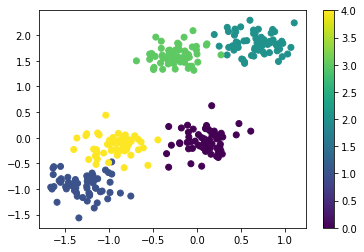

In [142]:
dg = ToyDataGenerator(dim=2, n_class=5)
x_train, y_train = dg.get_data(N_batch=300)

plt.scatter(x_train[:,0], x_train[:,1], c=y_train)
    
plt.colorbar()
plt.show()

## KerasのAPIを使った訓練 

TensorFlowはtfという名前でインポートするのがお作法のようです：

In [143]:
import tensorflow as tf

tfの中にkerasというモジュール群があります。kerasを使うと、簡単なニューラルネットワークの実装から訓練まで数行でできてしまいます！

### ニューラルネットワークを作る

tf.keras.models.Sequentialというコマンドに、順にどのようなニューラルネットワークの処理をさせたいか,で区切って書いていけば、そのようなネットワークを作ることができます。

> <font color=dodgerblue>**Sequentialモデルの作り方**</font>
> 
> ```python
> model = tf.keras.models.Sequential([0番目の層での処理,
>                                     1番目の層での処理,
>                                     ...,
>                                     最終層での処理])
>```
>>線形変換のち非線形変換をかける処理：
>> ```python
>> tf.keras.layers.Dense(出力次元, input_shape=(入力次元,), activation='非線形関数')
>> ```
>> input_shapeは0番目の処理でのみ必要。

In [144]:
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10, input_shape=(2,), activation='relu'),
                                     tf.keras.layers.Dense(8, activation='relu'),
                                     tf.keras.layers.Dense(5, activation='softmax')])

### どのように訓練するかを決める

> <font color=dodgerblue>**モデルの訓練設定**</font>
> 
> ```python
> model.compile(optimizer='勾配更新手法', loss='値を減らしたい目的関数')
> ```

In [145]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

### 訓練する

> <font color=dodgerblue>**モデルの訓練**</font>
> 
> ```python
> model.fit(x_train, y_train, epochs=データ何周するか数, batch_size=勾配更新に使うデータ数, verbose=履歴を出力するかどうか)
> ```
> 返り値がオブジェクトになっている。返り値.historyが辞書オブジェクトになっていて、いろいろな値の訓練中の履歴が取り出せる。

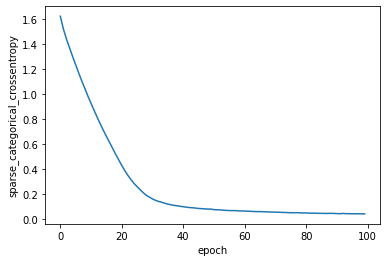

In [146]:
Hist= model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0)
# 学習曲線のプロット
plt.xlabel("epoch"); plt.ylabel("sparse_categorical_crossentropy")
plt.plot(np.arange(100), Hist.history['loss']);plt.show()

## 訓練結果を検証する

知らないデータを、どれくらい分類できるか？

```python
model.predict(x)
```

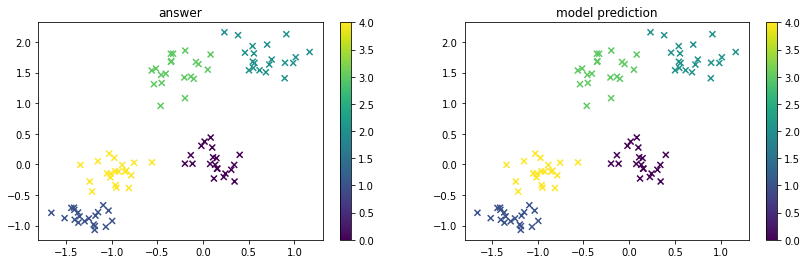

In [147]:
x_unknown, y_unknown = dg.get_data(100)

plt.figure(figsize=(14,4))

plt.subplot(1,2,1)
plt.title("answer")
plt.scatter(x_unknown[:,0], x_unknown[:,1], c=y_unknown, marker="x")
plt.colorbar()

plt.subplot(1,2,2)
plt.title("model prediction")
plt.scatter(x_unknown[:,0], x_unknown[:,1], c=np.argmax(model.predict(x_unknown), axis=1), marker="x")
plt.colorbar()

plt.show()

## もっと細かいことをやりたい場合

tf.keras.modelsのAPIで色々詳細に書くこともできます。詳しくは公式チュートリアル

- https://www.tensorflow.org/tutorials?hl=ja

を眺めてみるのがいいかと思います。